### Import libraries and dataset

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd

import tensorflow as tf

from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

from tensorflow import keras

from matplotlib import pyplot as plt
import math
from sklearn.metrics import r2_score

In [2]:
# Import raw data 
df = pd.read_csv('../csv/true_car_listings.csv')

### Data and Variable preparations 

In [3]:
### Exclusions

# drop if VIN or price is missing
df.drop(df[df['Vin'].isnull()].index, inplace = True)
df.drop(df[df['Price'].isnull()].index, inplace = True)

# Extremely high prices
df.drop(df[df['Price'] > 100000].index, inplace = True)


In [4]:
### Create age variable
### Built Year of a car can be translated easily from the VIN. Thus, we will create the numerical built_year variable
### Impact of built year on price is assume to be linear/ordinal, so we should use a numeric variable in this case
by_dict = {
'A':1980,'K':1989,'W':1998,'7':2007,'G':2016,
'B':1981,'L':1990,'X':1999,'8':2008,'H':2017,
'C':1982,'M':1991,'Y':2000,'9':2009,'J':2018,
'D':1983,'N':1992,'1':2001,'A':2010,'K':2019,
'E':1984,'P':1993,'2':2002,'B':2011,'L':2020,
'F':1985,'R':1994,'3':2003,'C':2012,'M':2021,
'G':1986,'S':1995,'4':2004,'D':2013,'N':2022,
'H':1987,'T':1996,'5':2005,'E':2014,'P':2023,
'J':1988,'V':1997,'6':2006,'F':2015,'R':2024}

df['year'] = df['Vin'].str[9].map(by_dict)

df.drop(df[df['year'].isnull()].index, inplace = True)

df['year'] = df['year'].astype(int) 

In [5]:
### Decompose VIN into categories that might be useful
### This categories will be used as embeddings later 
df['built_location'] = df['Vin'].str[0].astype(str) # Represents information on where car was built 
df['manufacturer'] = df['Vin'].str[1:3].astype(str) # Manufacturer
df['model_engine_fuel'] = df['Vin'].str[3:8].astype(str) # Combination of model, engine and fueltype 

In [11]:
for var in ['built_location', 'manufacturer', 'model_engine_fuel']:
    print('categories of ' + str(var) + ': {}'.format(len(df[var].unique())))

categories of built_location: 23
categories of manufacturer: 229
categories of model_engine_fuel: 12671


In [6]:
### Create dataframe with feature variables and drop missing values 
df_clean = df[['Price', 'built_location', 'manufacturer', 'year', 'model_engine_fuel']].dropna().copy()

### EDA & Lower bound Benchmark: Random prediction 

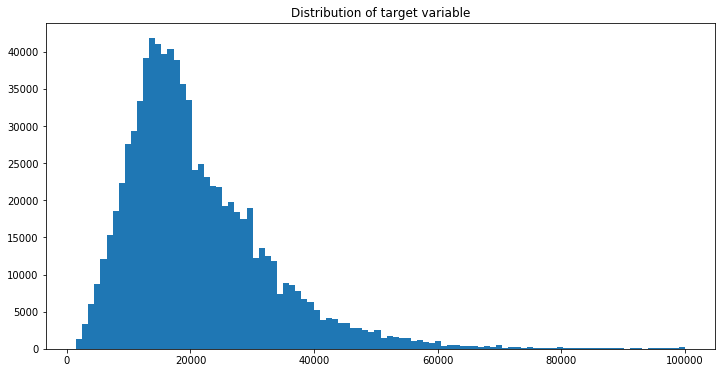

In [7]:
### Distribution of target variable 
df_pred = df_clean[['Price']].copy()

fig = plt.figure(figsize = (12,6))
plt.hist(df_pred[df_pred['Price']<100000]['Price'], bins = 100)
plt.title('Distribution of target variable')
plt.show()

In [12]:
# Make naive prediction, by just drawing randomly from the (Mean, STD) distribution that we observe above
# Underlying assumption that we have a normal distribution which we don't 
# (however, we just want a simple benchmark here)
mean = df_pred['Price'].mean()
std = df_pred['Price'].std()

df_pred['pred'] = np.random.normal(loc = mean, scale = std, size = len(df_pred))
df_pred['pred'] = df_pred['pred'].clip(lower = 0)

df_pred['mae'] = abs(df_pred['Price'] - df_pred['pred'])

In [13]:
print('Mean absolute error, if we naively predict from the observed distribution: {}'.format(round(df_pred['mae'].mean(),2)))

Mean absolute error, if we naively predict from the observed distribution: 13949.01


### Data prep for tensorflow model 

In [14]:
train, test = train_test_split(df_clean, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)

In [15]:
def df_to_dataset(df, shuffle=True, batch_size=32):
    dataframe = df.copy()
    
    labels = dataframe.pop('Price')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds 

In [16]:
batch_size = 200 
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [17]:
### Prepare embeddings 
feature_columns = list()
pre_embeddings = dict()
embedding = dict() 

for var in ['built_location', 'manufacturer', 'model_engine_fuel']:

    pre_embeddings[var] = feature_column.categorical_column_with_vocabulary_list(var,
                 df[var].unique())
    
    embedding[var] = feature_column.embedding_column(pre_embeddings[var], 
                      dimension = round(len(df_clean[var].unique()) ** 0.6))
    
    feature_columns.append(embedding[var])


year = feature_column.numeric_column('year')

feature_columns.append(year)

feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

### Model training 

In [18]:
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'),  
  layers.Dense(1)
])

model.compile(optimizer='adam',
              loss='mean_absolute_error',
              metrics=['mae'])

model.fit(train_ds,
          validation_data=val_ds,
          epochs=10)

Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10
2727/2727 [==============================] - 91s 33ms/step - loss: 5041.0041 - mae: 5041.1655 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/10
2727/2727 [==============================] - 83s 31ms/step - loss: 3165.8171 - mae: 3166.0005 - val_loss: 3078.7759 - val_mae: 3079.0676
Epoch 3/10
2727/2727 [==============================] - 88s 32ms/step - loss: 2999.5091 - mae: 2999.4944 - val_loss: 2987.6181 - val_mae: 2987.8203
Epoch 4/10
2727/2727 [==============================] - 89s 33ms/step - loss: 2920.8757 - mae: 2921.0645 - val_loss: 2930.0140 - val_mae: 2930.2329
Epoch 5/10
2727/2727 [==============================] - 90s 33ms/step - loss: 2872.1121 - mae: 2872.0107 - val_loss

In [ ]:
# Save model 
keras.models.save_model(model,
                       'nn_used_car')

In [ ]:
# Load model from disk
loaded_model = keras.models.load_model('nn_used_car')

In [21]:
### Calculate R-squared on test set predictions  
test['pred'] = model.predict(test_ds)
r2_score(test['Price'], test['pred'])

/Users/martin_bierey/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0.8512748202037898

Text(0.5, 1.0, 'True vs. predicted price')

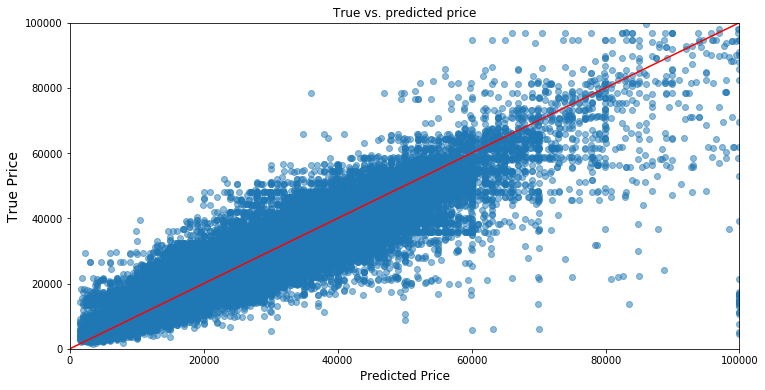

In [33]:
### Plot true vs pred
fig = plt.figure(figsize = (12,6))
plt.scatter(test['Price'], test['pred'], alpha = 0.5)
plt.plot(range(0,101000,1000), range(0,101000,1000), c = 'red')
plt.ylim([0, 100000])
plt.xlim([0, 100000])
plt.ylabel('True Price', fontsize = 14)
plt.xlabel('Predicted Price', fontsize = 12)
plt.title('True vs. predicted price')

### Conclusion 

- Taking only the information from one variable (VIN), we are able to predict 85% of the variance of used car prices (R-squared on test set)
- Compared to a naive (random) prediction, which yields an MAE of 14,000 USD, we decrease the MAE to below 2,800 USD
- Thus, it looks like there is important informational value in the VIN that could be used to improve existing 
  used car models 
- The model could certainly be further optimized, but this is not the aim of this capstone. Instead, we wanted to get a general feeling for how much informational value the VIN contains 